# HMM/sLDS

This notebook goes through models which assume the existence of *discrete states* that the system switches between. These can correspond to e.g behavioural states (walking/running, attentive/distracted). 

We will consider Hidden Markov Models, switching Linear Dynamical Systems, and recurrent switching Linear Dynamical Systems. We will show how to generate data from such models, and how to infer the hidden states from the data. 

### Table of contents

1. [**Hidden Markov Models**](#hmm)
2. [**switching Linear Dynamical System**](#slds)

l

## Load some packages
We make use of the [ssm](https://github.com/lindermanlab/ssm) and [dynamax](https://probml.github.io/dynamax) libraries throughout this notebook.
The ssm library can be installed as follows : 

```
git clone https://github.com/lindermanlab/ssm
cd ssm
pip install numpy cython
pip install -e .
```

In [1]:
import numpy as np
import jax
import jax.numpy as jnp

%load_ext autoreload
%autoreload 2

<a id='hmm'></a>
## Hidden Markov Model (HMM)

In the following, we consider that we have data Y that can be modelled using a Hidden Markov Model (HMM).

The HMM assumes the existence of a _latent state_ X, which can take $n$ possible values in {1, ..., $n$}.
At each point in time t, we denote the probability of being in state $j$ by $p(X_t = j)$. The evolution of the state is governed by a transition matrix $T \in \mathbb{R}^{n \times n}$, where $T_{ij}$ gives the probability of a transition from state $i$ to state $j$. 
The *emission model* gives the probability of observing $Y_t$ when in state $X_t$, i.e $P(Y_t | X_t)$ is the emission or output probability.

Thus, the HMM *generative model* consists of the following components : 
- a prior probability of being in each state $p_\theta(X_0 = j) = \pi_j$
- the transition probability to evolve from $i$ to $j$, $T_{ij}$
- the emission probability $P_\theta(Y_t | X_t)$ 

While X is not directly observable (it is _hidden_), we can gain observation about X from the observations Y. and use those to infer the state of X at a given time t. 

We can perform efficient *inference* in an HMM (i.e get the posterior probabilities over states given the data) using the forward-backward algorithm ([Murphy, 2023](https://github.com/probml/pml2-book/releases/tag/2022-10-16); Chapter 8.2.4).

We can also *learn* the parameters of the HMM models by optimizing $\theta$ to maximize the log likelihood of the data under the model.

## Spike sorting example

Below, we consider a simple application of the HMM model.  
Our observations consist of a spike train $Y$, where $Y_t$ corresponds to the number of spikes observed in a time bin $\Delta t = 20$ms. 

We assume we have 2 cells (cell 1 and cell 2) which have different baseline firing rates :
- cell 1 has a mean firing rate of 5Hz, such that the emission probability $P(Y_t | X = 1) = Poisson(5\Delta t)$.
- cell 2 has a mean firing rate of 20Hz, such that the emission probability $P(Y_t | X = 1) = Poisson(20\Delta t)$.

We moreover assume that we are recording from those cells with a slightly unstable electrode, which sometimes records from cell 1, and sometimes from cell 2. 
When the electrode is recording from one cell, the probability that it suddenly switches to the other cell is 0.8, such that $T = \begin{pmatrix}0.8 & 0.2 \\ 0.2 & 0.8\end{pmatrix}$. 


In [2]:
## Here, we generate observations from the above model
import dynamax

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import GaussianHMM, PoissonHMM
from jax import vmap
from functools import partial


dt = 0.05
num_states = 2      # two types of cells
num_emissions = 1   # only one cell is recorded from at a time

initial_probs = jnp.array([0.5, 0.5])
transition_matrix = jnp.array([[0.9, 0.1], 
                               [0.1, 0.9]])
emission_rates = jnp.array([[5.*dt],    # cell 1
                            [20.*dt]])  # cell 2


# Construct the HMM
hmm = PoissonHMM(num_states, num_emissions)

# Initialize the parameters struct with known values
params, _ = hmm.initialize(initial_probs=initial_probs,
                           transition_matrix=transition_matrix, emission_rates = emission_rates)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


true_states.shape: (300,)
emissions.shape: (300, 1)

First few states:     [1 1 1 1 1]
First few emissions:  [2. 1. 1. 1. 1.]


Text(0.5, 0, 'times (ms)')

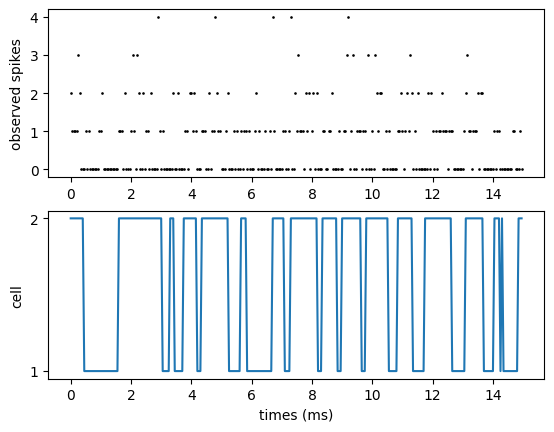

In [3]:
num_timesteps = 300
true_states, emissions = hmm.sample(params, jr.PRNGKey(42), num_timesteps)

print(f"true_states.shape: {true_states.shape}")
print(f"emissions.shape: {emissions.shape}")
print("")
print("First few states:    ", true_states[:5])
print("First few emissions: ", emissions[:5, 0])

fig, axes = plt.subplots(2,1)
axes[0].scatter(np.arange(np.shape(emissions)[0])*dt, emissions, color = "k", s = 0.8)
axes[0].set_ylabel("observed spikes")
axes[1].plot(np.arange(np.shape(emissions)[0])*dt,true_states)
axes[1].set_yticks([0,1], [1,2])
axes[1].set_ylabel("cell")
axes[1].set_xlabel("times (ms)")

## Perform inference

Here, we know the ground truth states and observations. However, let's assume that we only see the observations and we want to figure out which cell we are recording from at any time: we can achieve this by performing inference in the model (which here can be done using only one forward pass and one backward pass).


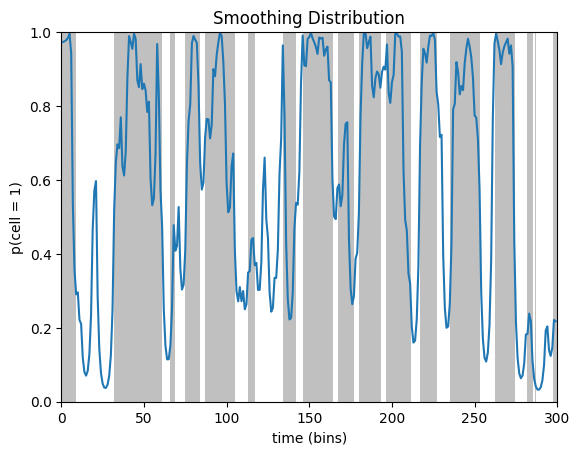

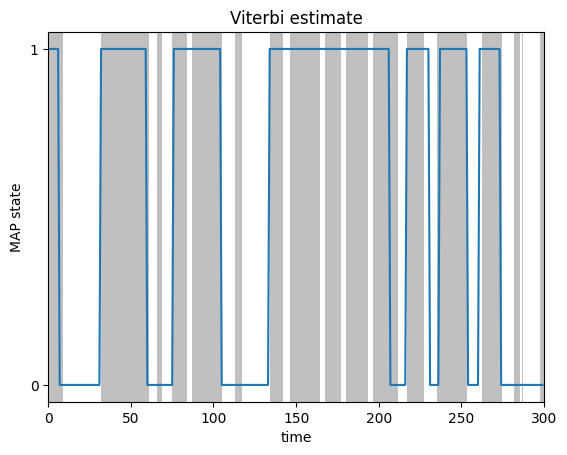

In [4]:
def plot_posterior_probs(probs, states, title=""):
    plt.figure()
    plt.imshow(states[None, :], extent=(0, num_timesteps, 0, 1), 
               interpolation="none", aspect="auto", cmap="Greys", alpha=0.25)
    plt.plot(probs[:, 1])   # probability of the loaded state (z=1)
    plt.xlabel("time (bins)")
    plt.ylabel("p(cell = 1)")
    plt.ylim(0, 1)
    plt.title(title)
    
    
def plot_map_sequence(most_likely_states, states):
    plt.imshow(states[None, :], extent=(0, num_timesteps, -0.05, 1.05), 
               interpolation="none", aspect="auto", cmap="Greys", alpha=0.25)
    plt.plot(most_likely_states)
    plt.xlabel("time")
    plt.ylabel("MAP state")
    plt.ylim(-0.05, 1.05)
    plt.yticks([0, 1])
    plt.title("Viterbi estimate")
posterior = hmm.smoother(params, emissions) #this yields a posterior over states using all the data at once 


plot_posterior_probs(posterior.smoothed_probs, true_states,
                     title="Smoothing Distribution")
plt.figure()
most_likely_states = hmm.most_likely_states(params, emissions)
plot_map_sequence(most_likely_states, true_states)

## Add the learning
Finally, in general we won't know the parameters of the model; we can learn them by maximizing the log likelihood of the data.

batch_states.shape:    (5, 5000)
batch_emissions.shape: (5, 5000, 1)
batch_states.shape:    (5, 5000)
batch_emissions.shape: (5, 5000, 1)


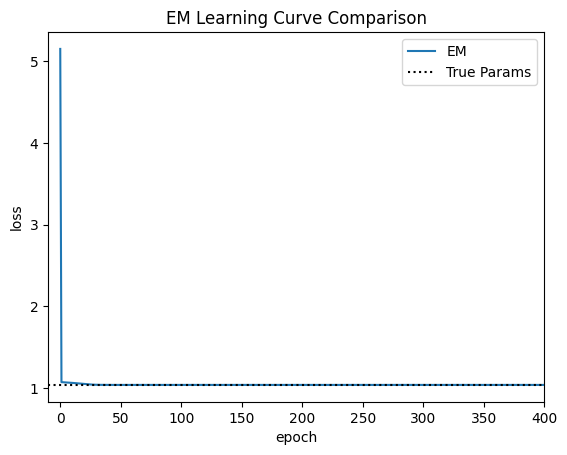

In [5]:
num_batches = 5
num_timesteps = 5000



batch_states, batch_emissions = \
    vmap(partial(hmm.sample, params, num_timesteps=num_timesteps))(
        jr.split(jr.PRNGKey(42), num_batches))

print(f"batch_states.shape:    {batch_states.shape}") 
print(f"batch_emissions.shape: {batch_emissions.shape}") 

batch_states, batch_emissions = \
    vmap(partial(hmm.sample, params, num_timesteps=num_timesteps))(
        jr.split(jr.PRNGKey(42), num_batches))

print(f"batch_states.shape:    {batch_states.shape}") 
print(f"batch_emissions.shape: {batch_emissions.shape}") 

key = jr.PRNGKey(0)
em_params, em_param_props = hmm.initialize(key)
em_params, log_probs = hmm.fit_em(em_params, 
                                  em_param_props, 
                                  batch_emissions, 
                                  num_iters=400)

# Compute the "losses" from EM 
em_losses = -log_probs / batch_emissions.size 

# Compute the loss if you used the parameters that generated the data
true_loss = vmap(partial(hmm.marginal_log_prob, params))(batch_emissions).sum()
true_loss += hmm.log_prior(params)
true_loss = -true_loss / batch_emissions.size

# Plot the learning curves
plt.figure()
plt.plot(em_losses, label="EM")
plt.axhline(true_loss, color='k', linestyle=':', label="True Params")
plt.legend()
plt.xlim(-10, 400)
plt.xlabel("epoch")
plt.ylabel("loss")
_ = plt.title("EM Learning Curve Comparison")



Accuracy of the cell predictions : 84.333336 %


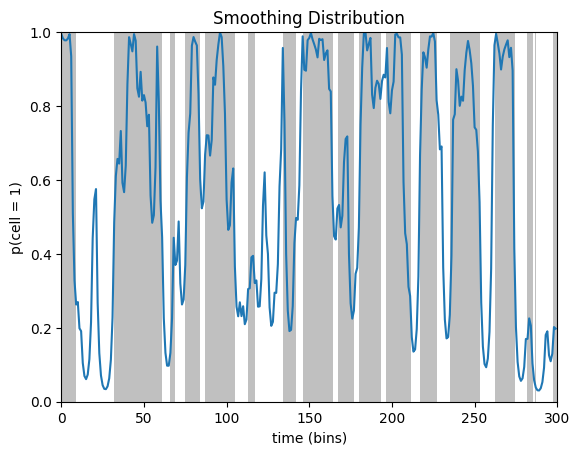

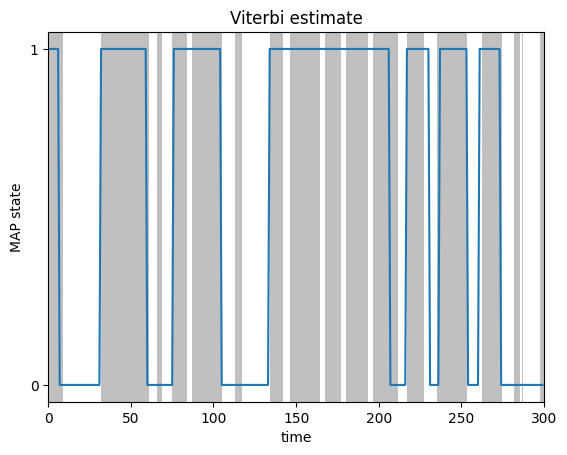

In [6]:
num_timesteps = 300
true_states, emissions = hmm.sample(params, jr.PRNGKey(42), num_timesteps)
inf_posterior = hmm.smoother(em_params, emissions) #this yields a posterior over states using all the data at once 

plot_posterior_probs(inf_posterior.smoothed_probs, true_states,
                     title="Smoothing Distribution")

plt.figure()
most_likely_states = hmm.most_likely_states(em_params, emissions)
plot_map_sequence(most_likely_states, true_states)

print("Accuracy of the cell predictions :", 100*np.sum((most_likely_states==true_states))/num_timesteps, "%")

## Takeaways 

Here, we saw an example of using an HMM model to figure out which cell our noisy electrode is recording from, from a series of observed spikes. We see that in this example, having this generative model (which is the ground truth one) allows us to sort the cells with 84% accuracy. 

<a id='slds'></a>
## Switching Linear Dynamical System

In the above case, we consider a generative model in which the only dynamics in the latent space are the switches between states.
However, an extension of this is the case in each *each state has its own dynamics*. For instance, each state $i$ can correspond to a different behaviour (walking, cycling, running), and when in this state, the system evolves according to a set of dynamics $A_i$. 
If the dynamics are linear in each individual state, this corresponds to a *switching Linear Dynamical System* model.

The generative model of a simple switching Linear Dynamical System is as follows : 
- you have $n$ possible states $s$
- transitions between states are given by $P(s_t = i | s_t = j) = T_{ij}$
- when in state $i$, the latent dynamical system evolves as $x_{t+1} = A^i x_t + b^i + w^i_t$ where $w$ denotes process noise (with a state-specific covariance)
- the emission model is given by $P(y_t | x_t)$ 

Below, we will see examples of data generated by a switching LDS, and of inference and learning in this model.
We will rely on functions from the ssm library, which needs to be installed. 

Note that we could potentially make the model more rich by eg making the transitions dependent on the current state (as in a recurrent switching LDS), or introducing external inputs $u$ into the dynamics.

## Switching behaviour example

Below, we consider a simple application of the sLDS model.
We will assume we have behavioural observations from an animal which is i) moving to the right, ii), moving up or iii) walking slowly in circles around a room or iv) walking in circles very fast around a room.

We have multiple sensors located on the animal, such that our observations consist of a 20-dimensional vector of gaussian observations $Y \in \mathbb{20 \times 20}$. The latent dynamics are however assumed to be 2-D.

We have 4 behaviours, with the following dynamical properties : 
- in state 1, the animal is moving to the right, i.e  $A^1 = 0$, $b^1 = \begin{pmatrix}1 \\ 0\end{pmatrix}$. 
- in state 2, the animal is moving to the right, i.e  $A^2 = 0$, $b^2 = \begin{pmatrix}0 \\ 1\end{pmatrix}$. 
- in state 3, the animal is moving in circles, i.e  $A^3 = \begin{pmatrix}1 & 1 \\ -1 & 1 \end{pmatrix}$, $b^3 = 0$ (rotation frequency = 0.1).
- in state 4, the animal is moving in circles but faster, $A^4 = \begin{pmatrix}1 & 5 \\ -5 & 1 \end{pmatrix}$, $b^3 = 0$ (rotation frequency = 5).



In [108]:
import ssm 
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import ssm
from ssm.util import random_rotation, find_permutation

In [109]:
# Set the parameters of the SLDS
T = 1000    # number of time bins
K = 4     # number of discrete states : walking right, up, and two circling frequencies 
D = 2       # number of latent dimensions  
N = 20    # number of observed dimensions
dt = 0.05 
# Make an SLDS with the true parameters
true_slds = ssm.SLDS(N, K, D, emissions="gaussian")
# Set dynamics
As = [np.zeros(shape = (2,2)), np.zeros(shape = (2,2)), np.asarray([[1., 1.0*dt], [-1.0*dt, 1]]), np.asarray([[1., 5.0*dt], [-5.0*dt, 1]])]
bs = [np.asarray([1, 0])*dt, np.asarray([0,1])*dt, np.zeros(2), np.zeros(2)]
for k in range(K):
    true_slds.dynamics.As[k] = As[k]
    true_slds.dynamics.bs[k] = bs[k]


Text(0.5, 0, 'time')

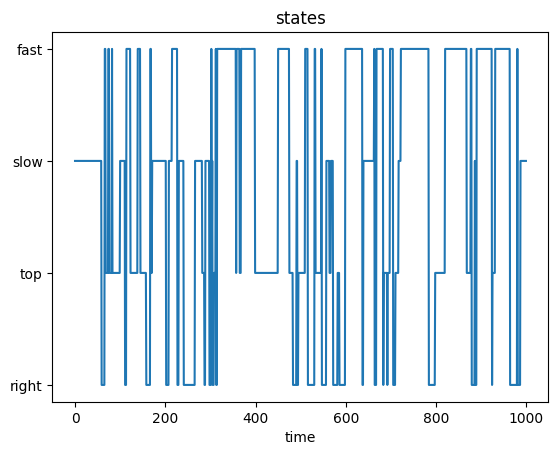

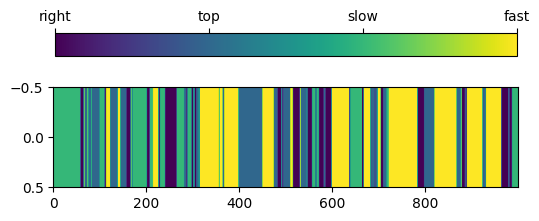

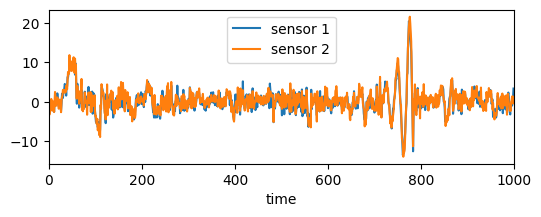

In [110]:
# Sample data
s, x, y = true_slds.sample(T)

plt.title("states")
plt.plot(s)
plt.xlabel("time")
plt.yticks([0, 1, 2, 3], ["right", "top", "slow", "fast"])

fig, ax = plt.subplots(figsize = (6,2))
cax = ax.imshow(np.column_stack((s)), aspect="auto")
cbar = fig.colorbar(cax, ticks=[0,1,2,3],orientation="horizontal", location="top", pad=0.2)
cbar.ax.set_xticklabels(['right', 'top', 'slow', 'fast'])


fig, ax = plt.subplots(figsize = (6,2))
ax.plot(y[:,0], label = "sensor 1")
ax.plot(y[:,1], label = "sensor 2")
ax.set_xlim(0,1000)
ax.legend()
ax.set_xlabel("time")

Fitting SLDS with Laplace-EM


  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

(0.0, 1000.0)

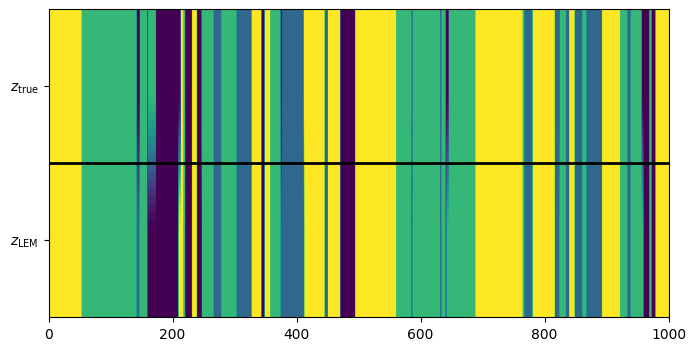

In [106]:
# Fit an sLDS to the data 
#Here, we use the Laplace-EM method to fit the sLDS; this will do successive steps of computing the posterior (using a Laplace approximation around the MAP estimate) and optimizing the parameters to maximize the log likelihood under this posterior. Other fitting methods are implemented and discussed in the ssm library.


print("Fitting SLDS with Laplace-EM")


slds = ssm.SLDS(N, K, D, emissions="gaussian_orthog") #we create the model
q_lem_elbos, q_lem = slds.fit(y, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               num_iters=100, alpha=0.0)

q_lem_x = q_lem.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(s, slds.most_likely_states(q_lem_x, y)))
q_lem_z = slds.most_likely_states(q_lem_x, y)

# Smooth the data under the variational posterior
q_lem_y = slds.smooth(q_lem_x, y)
# Plot the true and inferred states
xlim = (0, 1000)

plt.figure(figsize=(8,4))
plt.imshow(np.column_stack((s, q_lem_z)).T, aspect="auto")
plt.plot(xlim, [0.5, 0.5], '-k', lw=2)
plt.yticks([0, 1], ["$z_{\\mathrm{true}}$", "$z_{\\mathrm{LEM}}$"])
plt.xlim(xlim)

We see that even though we don't exactly recover the model, we can identify most of the states


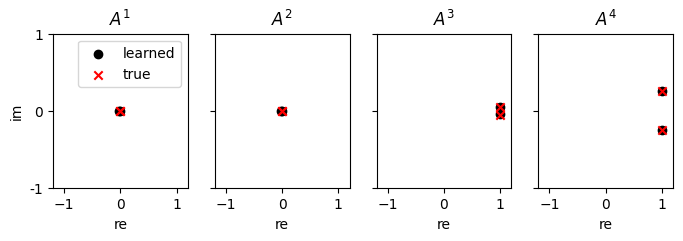

In [107]:
#Finally, we can look at the learned parameters
#the model is very good at recovering the true eigenvalues, which allow us to see for instance which states are rotational or not
fig, axes = plt.subplots(1,4, figsize = (8,2))
for k in range(K):
    axes[k].set_xlim(-1.2,1.2)
    axes[k].set_ylim(-1,1)
    learned_eigs = np.linalg.eigvals(slds.dynamics.As[k])
    true_eigs = np.linalg.eigvals(true_slds.dynamics.As[k])
    axes[k].scatter(np.real(learned_eigs), np.imag(learned_eigs), color = 'k', label = "learned")
    axes[k].scatter(np.real(true_eigs), np.imag(true_eigs), marker = 'x', color = 'r', label = "true")
    axes[k].set_xlabel("re")
    axes[k].set_title(f"$A^{k + 1}$")
    if k == 0:
        axes[k].legend()
        axes[k].set_yticks([-1,0,1], [-1,0,1])
        axes[k].set_ylabel("im")
    else : 
        axes[k].set_yticks([-1,0,1], [])
        

## Summary

In this notebook, we saw two examples of generative models with discrete states, and discrete + continuous states. Those models have the advantage that discrete states can help with _interpreting_ the model. In our examples, using such a generative model allowed to perform spike sorting, while in the second case it allowed to cluster behaviour.